## Bike Share System Rebalancing with ACO and GA

In this project, we used two datasets - Bike Share Toronto Ridership Data, and Bike Share Toronto Station Information Data. The first dataset is the Bike Share Toronto Ridership Data(https://open.toronto.ca/dataset/bike-share-toronto-ridership-data/). The second dataset we compiled to locate each bike station is the station information data from Bike Share Toronto(https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information).

We first preprocessed the data and cleansed the irrelevant data, and then specifically picked the stations in downtown Toronto as points of interest. Then we go through the ridership data to estimate the demand gap for each station. The optimization goal would be to minimize the sum of these gaps across the 20 bike stations in downtown Toronto.

We implemented two algorithms: ACO and GA, with GA's adaptive version supported. The results show that the multi-objective optimization problem has many criteria, and based on the three criteria: 1) minimizing distance, 2) maximizing the bike rebalancing task's completion progress and 2) minimizing the ratio of these two values, we can generate decent routes for the bike rebalancing operator.

For data preprocessing, please refer to out github: https://github.com/duanxdddd/ECE1724_project/tree/main/dataset

In [1]:
import pandas as pd
from turfpy.measurement import boolean_point_in_polygon
from geojson import Point, Polygon, Feature

# load station data
# rough boundaries for downtown Toronto
bbox_dt = [(43.665157, -79.411268), 
           (43.634167, -79.396763), 
          (43.651062, -79.347153),
          (43.675527, -79.361652)];

polygon = Polygon(
    [
        bbox_dt
    ]
)

# find all the stations in downtown Toronto
stations_df = pd.read_csv('stations.csv', index_col=0)
not_in_dt_station_list = []
total_num_stations = stations_df.shape[0]
for index, row in stations_df.iterrows():
    point = Feature(geometry=Point((row.lat, row.lon)))
    if not boolean_point_in_polygon(point, polygon):
        not_in_dt_station_list.append(index)
stations_df.drop(not_in_dt_station_list, axis=0, inplace=True)
stations_df.reset_index()
print("number of bike stations in downtown Toronto: ", total_num_stations - len(not_in_dt_station_list))
stations_df.reset_index(drop=True, inplace=True)

stations = stations_df
stations_df

number of bike stations in downtown Toronto:  220


,station_id,name,lat,lon,address,capacity
0,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954,Fort York Blvd / Capreol Ct,35
1,7001,Wellesley Station Green P,43.664964,-79.383550,Yonge / Wellesley,26
2,7002,St. George St / Bloor St W,43.667333,-79.399429,St. George St / Bloor St W,19
3,7004,University Ave / Elm St,43.656518,-79.389099,University Ave / Elm St,11
4,7005,King St W / York St,43.648001,-79.383177,King St W / York St,19
...,...,...,...,...,...,...
215,7718,St. Andrew's Playground Park,43.646151,-79.399821,8 Maud Street,11
216,7719,Wolseley St / Augusta Ave,43.648420,-79.400519,15 Denison Ave,28
217,7720,King St W / Portland St,43.644395,-79.400654,620 King Street West,16
218,7721,Widmer St / King St W,43.646357,-79.391206,360 King Street West,11


In [198]:
# load ridership data
ridership_df = pd.read_csv('ridership.csv')
ridership_df

,Unnamed: 0,start_time,end_time,startSID,endSID,BID
0,0,09/01/2022 00:00,09/01/2022 00:08,7155,7256.0,5458
1,1,09/01/2022 00:00,09/01/2022 00:05,7245,7069.0,6241
2,2,09/01/2022 00:00,09/01/2022 00:05,7060,7270.0,4393
3,3,09/01/2022 00:00,09/01/2022 00:20,7204,7430.0,5298
4,4,09/01/2022 00:00,09/01/2022 00:10,7417,7026.0,5756
...,...,...,...,...,...,...
602662,602662,09/30/2022 23:59,10/01/2022 00:03,7654,7466.0,6443
602663,602663,09/30/2022 23:59,10/01/2022 00:34,7199,7581.0,2258
602664,602664,09/30/2022 23:59,10/01/2022 00:12,7548,7458.0,4978
602665,602665,09/30/2022 23:59,10/01/2022 00:21,7016,7079.0,6407


In [3]:
# import librairies
import numpy as np
import pandas as pd
import time 
import requests
import json
import networkx as nx
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [13,11]

In [4]:
data = pd.read_csv('ridership.csv', parse_dates = ['start_time', 'end_time'], dayfirst=True, index_col=0)
data.endSID = data.endSID.astype(int)
data

,start_time,end_time,startSID,endSID,BID
0,2022-01-09 00:00:00,2022-01-09 00:08:00,7155,7256,5458
1,2022-01-09 00:00:00,2022-01-09 00:05:00,7245,7069,6241
2,2022-01-09 00:00:00,2022-01-09 00:05:00,7060,7270,4393
3,2022-01-09 00:00:00,2022-01-09 00:20:00,7204,7430,5298
4,2022-01-09 00:00:00,2022-01-09 00:10:00,7417,7026,5756
...,...,...,...,...,...
602662,2022-09-30 23:59:00,2022-01-10 00:03:00,7654,7466,6443
602663,2022-09-30 23:59:00,2022-01-10 00:34:00,7199,7581,2258
602664,2022-09-30 23:59:00,2022-01-10 00:12:00,7548,7458,4978
602665,2022-09-30 23:59:00,2022-01-10 00:21:00,7016,7079,6407


In [5]:
stations = stations_df
stations['station_id'] = stations.station_id.astype(int)
checkSID_series = data.startSID.isin(stations['station_id'])
checkSID_series_end = data.endSID.isin(stations['station_id'])
check_data = pd.concat([checkSID_series, checkSID_series_end])
check_data
remove_list = set()
for index, value in check_data.items():
    if value == False:
        if index not in remove_list:
            remove_list.add(index)
len(remove_list)

323168

In [6]:
# delete 323168 ridership rows with invalid bike station info
data.drop(remove_list, axis=0, inplace=True)
data.reset_index(inplace=True, drop=True)
data

,start_time,end_time,startSID,endSID,BID
0,2022-01-09 00:00:00,2022-01-09 00:08:00,7155,7256,5458
1,2022-01-09 00:00:00,2022-01-09 00:05:00,7060,7270,4393
2,2022-01-09 00:00:00,2022-01-09 00:10:00,7417,7026,5756
3,2022-01-09 00:00:00,2022-01-09 00:06:00,7030,7007,3443
4,2022-01-09 00:00:00,2022-01-09 00:12:00,7491,7281,5903
...,...,...,...,...,...
279494,2022-09-30 23:58:00,2022-01-10 00:14:00,7257,7257,5943
279495,2022-09-30 23:58:00,2022-01-10 00:06:00,7391,7374,232
279496,2022-09-30 23:58:00,2022-01-10 00:06:00,7033,7043,6138
279497,2022-09-30 23:59:00,2022-01-10 00:12:00,7548,7458,4978


In [7]:
from sklearn.cluster import KMeans
X = stations[['lon', 'lat']].values
n_clusters_ = 19
kmeans = KMeans(n_clusters = n_clusters_, init ='k-means++')
kmeans.fit(X) # Compute k-means clustering.
labels = kmeans.fit_predict(X)

In [8]:
# Coordinates of cluster centers.
centers = kmeans.cluster_centers_ 

# map each station with its region
stations['cluster']=labels
stations.index=stations['station_id']
cluster_map = stations['cluster'].to_dict()
data['from_station_c']=data['startSID'].map(cluster_map)
data['to_station_c']=data['endSID'].map(cluster_map)


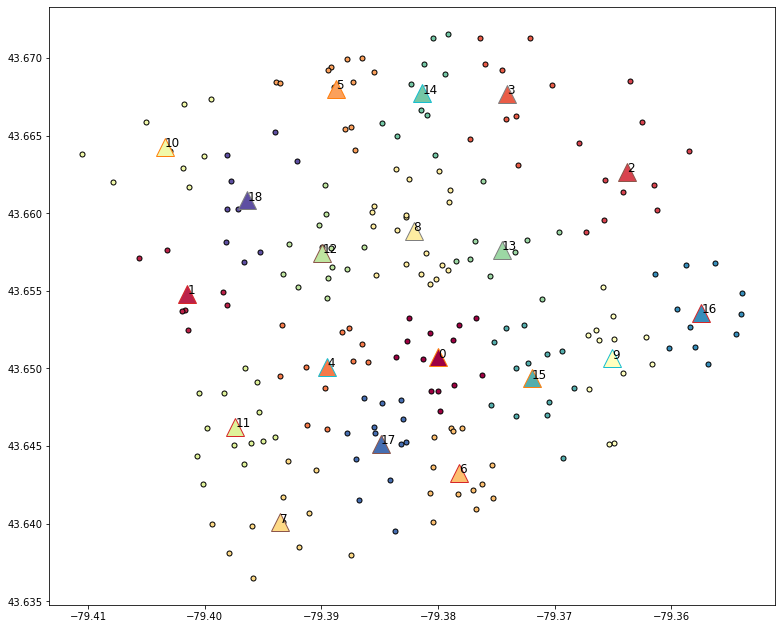

In [9]:
import matplotlib.image as mpimg
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
# BBox = (-79.4900,-79.2700,43.6100,43.7200)
# map_tor = mpimg.imread('map.png')
fig, ax = plt.subplots()
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask]
    ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)
    ax.plot(centers[k, 0], centers[k, 1], '^',markerfacecolor=tuple(col), markersize=18)
    ax.text(centers[k, 0], centers[k, 1], k,fontsize=12)
# ax.set_xlim(BBox[0],BBox[1])
# ax.set_ylim(BBox[2],BBox[3])
# ax.imshow(map_tor, zorder=0, extent = BBox, aspect= 'equal')
plt.show()


In [10]:
import folium
stations1 = stations.copy()
stations1.reset_index(drop=True, inplace=True)

locations = stations1[['lat', 'lon']]
locationlist = locations.values.tolist()
color_list = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
map = folium.Map(location=[43.657366, -79.378528], zoom_start=14)
for point in range(0, len(locationlist)):
    if locationlist[point]== [0.0, 0.0]: continue
    folium.Marker(locationlist[point], icon=folium.Icon(color=color_list[stations1['cluster'][point]],icon='map-marker', prefix='fa'), popup=stations1['cluster'][point]).add_to(map)
map



In [11]:
df = data
df['from_station_id'] = data['startSID']
df['to_station_id'] = data['endSID']
df['region_count']=(df['from_station_c']<df['to_station_c']).astype(int)-(df['from_station_c']>df['to_station_c']).astype(int)
df['region_key'] = df[['from_station_c','to_station_c']].min(axis=1).astype('str') +'_'+ df[['from_station_c','to_station_c']].max(axis=1).astype('str')

df['station_count']=(df['from_station_id']<df['to_station_id']).astype(int)-(df['from_station_id']>df['to_station_id']).astype(int)
df['station_key'] = df[['from_station_id','to_station_id']].min(axis=1).astype('str') +'_'+ df[['from_station_id','to_station_id']].max(axis=1).astype('str')
# Hour of the day
df['hour'] = df['start_time'].dt.hour
# Day of the week
df['dayofweek'] = df['start_time'].dt.dayofweek
# Date
df['date'] = df['start_time'].dt.floor('d')

df.describe(include=['O'])
df.columns

Index(['start_time', 'end_time', 'startSID', 'endSID', 'BID', 'from_station_c',
       'to_station_c', 'from_station_id', 'to_station_id', 'region_count',
       'region_key', 'station_count', 'station_key', 'hour', 'dayofweek',
       'date'],
      dtype='object')

In [12]:
##############################
# Extract flows and create graph
##############################

def getFlows(region=True,start_date=pd.Timestamp('2022-01-01'),end_date=pd.Timestamp('2023-01-01'),days = [0,1,2,3,4,5,6]):
    # flows
    if region:
        flows = df.loc[(df['from_station_c']!=df['to_station_c'])&(df['dayofweek'].isin(days)) & (df['date']>=start_date) & (df['date']<end_date) ].groupby(['region_key'])['region_count'].sum()
    else:
        flows = df.loc[(df['from_station_id']!=df['to_station_id'])&(df['dayofweek'].isin(days)) & (df['date']>=start_date) & (df['date']<end_date) ].groupby(['station_key'])['station_count'].sum()
    # graph
    G = nx.DiGraph()
    for index, value in flows.items():
        G.add_weighted_edges_from([(int(index.split('_')[0]), int(index.split('_')[1]), value)])
    # degrees of each nodes
    nodes=[]
    degrees=[]
    for e in G:
        nodes.append(e)
        degrees.append(G.in_degree(e, weight='weight')-G.out_degree(e, weight='weight'))
    deg = pd.Series(data=degrees,index=nodes).sort_values()
    return flows,G,deg

f_stations_w, g_stations_w , d_stations_w = getFlows(region=False,start_date=pd.Timestamp('2022-01-01'),end_date=pd.Timestamp('2023-01-01'),days = [0,1,2,3,4])
f_stations_we, g_stations_we , d_stations_we = getFlows(region=False,start_date=pd.Timestamp('2022-01-01'),end_date=pd.Timestamp('2023-01-01'),days = [5,6])
f_regions_w, g_regions_w , d_regions_w = getFlows(region=True,start_date=pd.Timestamp('2022-01-01'),end_date=pd.Timestamp('2023-01-01'),days = [0,1,2,3,4])
f_regions_we, g_regions_we , d_regions_we = getFlows(region=True,start_date=pd.Timestamp('2022-01-01'),end_date=pd.Timestamp('2023-01-01'),days = [5,6])

In [13]:
top10 = pd.DataFrame(np.vstack([d_stations_w.iloc[:10].index.values,d_stations_w.iloc[-10:].index.values,d_stations_we.iloc[:10].index.values,d_stations_we.iloc[-10:].index.values]).transpose()
                                     ,columns=["Negative_Week","Positive_Week","Negative_Weekend","Positive_Weekend"])
station_name_dict = pd.Series(stations.name.values,index=stations.station_id).to_dict()
top10["Negative_Week"] = top10["Negative_Week"].map(station_name_dict)
top10["Positive_Week"] = top10["Positive_Week"].map(station_name_dict)
top10["Negative_Weekend"] = top10["Negative_Weekend"].map(station_name_dict)
top10["Positive_Weekend"] = top10["Positive_Weekend"].map(station_name_dict)

top10

,Negative_Week,Positive_Week,Negative_Weekend,Positive_Weekend
0,Bay St / Wellesley St W,Simcoe St / Queen St W,Bay St / Wellesley St W,King St E / Jarvis St
1,Dundonald St / Church St,College St / Major St,Dundonald St / Church St,Dundas St E / Regent Park Blvd
2,Adelaide St W / Brant St,HTO Park (Queens Quay W),Sherbourne St / Wellesley St E,Queens Quay W / Dan Leckie Way
3,Sherbourne St / Wellesley St E,Phoebe St / Spadina Ave,20 Charles St E,York St / Queens Quay W
4,Spadina Ave / Sussex Ave - SMART,Soho St / Queen St W,Adelaide St W / Brant St,Front St W / Yonge St (Hockey Hall of Fame)
5,Isabella St / Church St,Front St W / Yonge St (Hockey Hall of Fame),Isabella St / Church St,Wellington St W / Bay St
6,The Royal Ontario Museum (Bloor St Entrance),Wellington St W / Bay St,Bay St / Charles St - SMART,Phoebe St / Spadina Ave
7,University Ave / Gerrard St W (WEST) - SMART,University Ave / Gerrard St W (East Side),Spadina Ave / Sussex Ave - SMART,King St W / Bay St (West Side)
8,Ted Rogers Way / Bloor St E,Union Station,The Royal Ontario Museum (Bloor St Entrance),Union Station
9,Willcocks St / St. George St,King St W / Bay St (West Side),Jarvis St / Isabella St,HTO Park (Queens Quay W)


In [14]:
############################################################
# Plot the graphs
############################################################
def plot_G_stations(G,degrees,ptitle=""):
    colors=[]
    pos={}
    node_sizes=[]
    max_deg = degrees.abs().max()
    labels={}
    for e in G:
        d=degrees[e]
        node_sizes.append(100 + 500*(abs(d)/max_deg))
        pos[int(e)]=(stations.loc[e,'lon'],stations.loc[e,'lat'])
        labels[int(e)]=(int(d))
        if d==0:
            colors.append('#00aedb')
        elif d < 0:
            colors.append('#f37735')
        else: 
            colors.append('#00b159')
    nx.draw_networkx_nodes(G,pos, node_size=node_sizes,node_color=colors)
    nx.draw_networkx_labels(G, pos,labels= labels, font_size=7)
    plt.title(ptitle)
    plt.show()



def plot_G_regions(G,flows,degrees,ptitle=""):
    colors=[]
    pos={}
    max_deg = degrees.abs().max()
    node_sizes=[]
    labels={}
    for e in G:
        d=degrees[e]
        node_sizes.append(100 + 600*(abs(d)/max_deg))
        pos[int(e)]=(centers[e,0],centers[e,1])
        labels[int(e)]=(int(d))
        if d==0:
            colors.append('#00aedb')
        elif d < 0:
            colors.append('#f37735')
        else: 
            colors.append('#00b159')

    color_cut_pos = flows[flows>0].median()
    color_cut_neg = flows[flows<0].median()

    elargepos = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >color_cut_pos]
    elargeneg = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] < color_cut_neg]
    eother = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >= color_cut_neg and d['weight'] <= color_cut_pos]

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes,node_color=colors,alpha=0.9)

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=elargepos,edge_color='#00b159', width=4,alpha=0.7)
    nx.draw_networkx_edges(G, pos, edgelist=elargeneg,edge_color='#f37735', width=4,alpha=0.7)
    nx.draw_networkx_edges(G, pos, edgelist=eother,edge_color='#00aedb', width=1,alpha=0.5)

    # labels
    nx.draw_networkx_labels(G, pos, labels= labels,font_size=14)
    plt.title(ptitle)
    plt.show()

### The following maps show the accumulated difference in number of bikes in its region/station
It also indicates that the number of bikes are not balanced in these points/regions of interest.

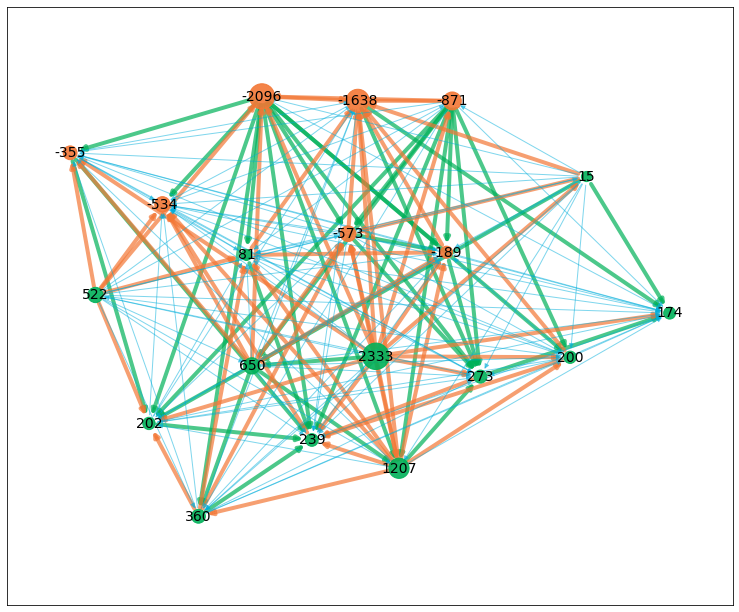

In [15]:
# weekdays
plot_G_regions(g_regions_w,f_regions_w,d_regions_w)

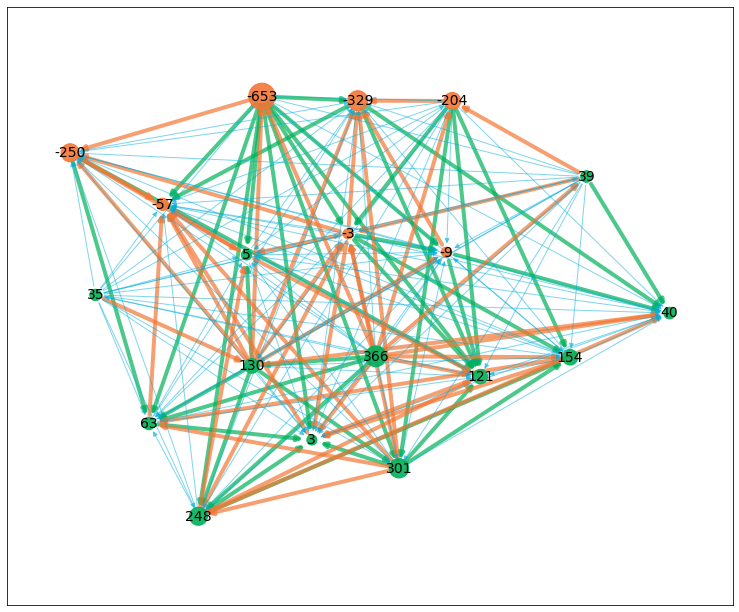

In [16]:
# weekends
plot_G_regions(g_regions_we,f_regions_we,d_regions_we)

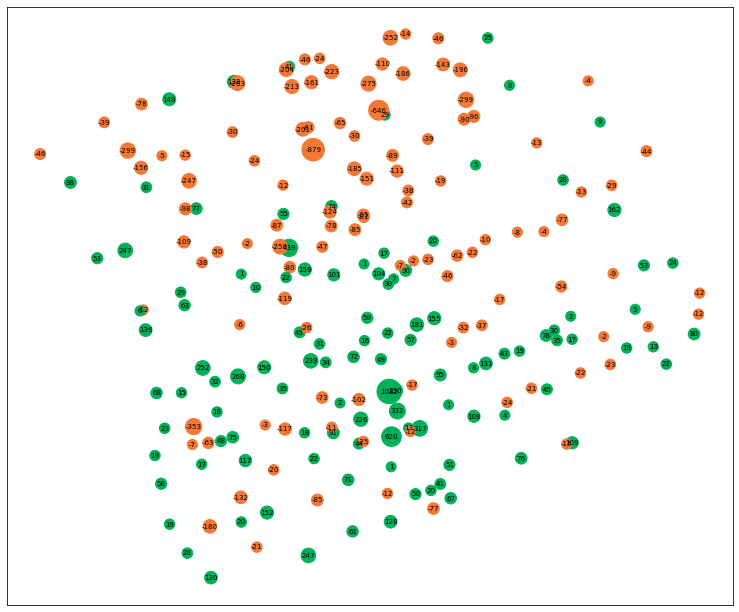

In [17]:
plot_G_stations(g_stations_w,  d_stations_w)

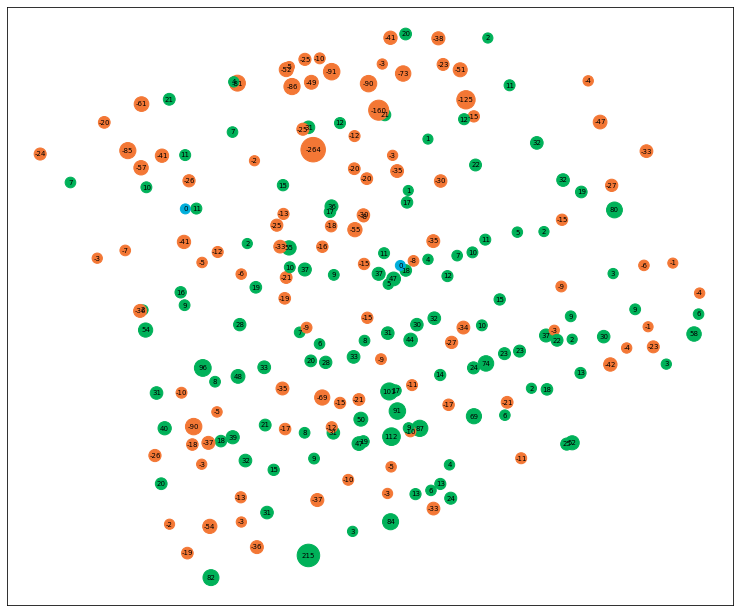

In [18]:
plot_G_stations(g_stations_we,  d_stations_we)

#### Next, we need to calculate the potential demand for each station.

In [19]:
import datetime as dt
start = df['start_time'].min().to_pydatetime()
end = df['start_time'].max().to_pydatetime()

weekdays = np.busday_count(start.date(), end.date())
days = (end.date() - start.date()).days
weekends = days - weekdays
print("There are ", days, " days, ", weekdays, " are weekdays and ", weekends, " are weekends.")

There are  334  days,  239  are weekdays and  95  are weekends.


In [20]:
# calculate the average offset for weekdays and weekends respectively
print("--- average bike offset on weekdays ---")
print(d_stations_w / weekdays)
print("\n--- average bike offset on weekends ---")
print(d_stations_we / weekends) # median

--- average bike offset on weekdays ---
7030   -3.677824
7024   -2.702929
7463   -1.476987
7042   -1.251046
7667   -1.251046
          ...   
7048    1.326360
7052    1.389121
7047    1.836820
7033    2.594142
7015    4.527197
Length: 220, dtype: float64

--- average bike offset on weekends ---
7030   -2.778947
7024   -1.684211
7042   -1.315789
7385   -0.957895
7463   -0.947368
          ...   
7052    0.957895
7020    1.010526
7015    1.063158
7033    1.178947
7175    2.263158
Length: 220, dtype: float64


In [21]:
# set absolute value of threashold to 1
thresh = 1
offset_w = d_stations_w / weekdays
nodes = []
for index, value in offset_w.items():
    if abs(value) >= thresh:
        nodes.append((index, value))
print(nodes, "\nTotal number of stations that needs to be rebalanced = ", len(nodes))

[(7030, -3.6778242677824267), (7024, -2.702928870292887), (7463, -1.4769874476987448), (7042, -1.2510460251046025), (7667, -1.2510460251046025), (7409, -1.1506276150627615), (7251, -1.100418410041841), (7634, -1.0794979079497908), (7025, -1.0543933054393306), (7066, -1.0334728033472804), (7022, 1.0), (7078, 1.0334728033472804), (7175, 1.0334728033472804), (7020, 1.0543933054393306), (7217, 1.1213389121338913), (7048, 1.3263598326359833), (7052, 1.389121338912134), (7047, 1.8368200836820083), (7033, 2.594142259414226), (7015, 4.527196652719665)] 
Total number of stations that needs to be rebalanced =  20


In [296]:
# run the ACO algorithm on the 20 stations with single vehicle

import pandas as pd
from smart_mobility_utilities.poi import poi
from smart_mobility_utilities.poi import drawRouteOrder
from smart_mobility_utilities.problem import ordOne_crossover, swap_mutation
from copy import deepcopy
import random
from heapq import nlargest, nsmallest
import matplotlib.pyplot as plt
import time

# Import location data
not_in_dt_depots = []
depots = pd.read_csv("depots.csv")
for index, row in depots.iterrows():
    point = Feature(geometry=Point((row.lat, row.lng)))
    if not boolean_point_in_polygon(point, polygon):
        not_in_dt_depots.append(index)
depots.drop(not_in_dt_depots, axis=0, inplace=True)
depot_nodes = [poi(row['address'],'canada',row['lat'],row['lng']) for index, row in depots.iterrows()]
depots.reset_index(inplace=True, drop=True)
depots

,address,lat,lng
0,533 King St W,43.644789,-79.398277
1,512 Church St,43.664656,-79.380577
2,65 Navy Wharf Ct,43.641382,-79.391432
3,35 The Esplanade,43.646443,-79.375100
4,249 Queens Quay W,43.638840,-79.385941
5,155 Wellesley St E,43.666518,-79.375275


In [23]:
# One correct way to approximate the demand for each bike station is to calculate the average number of bikes
# before the rebalancing every day/night. However, because the stations status API is on a real-time basis, we do not
# have the record of data across the same period of time. Thus, we are only using a temporary data in the midnight
# from the API to demonstrate a common status before rebalancing takes act. The data has a timestamp 1670993188 
# which converts to 
# Tue Dec 13 2022 23:46:28 GMT-0500 (Eastern Standard Time).

# Note that this is only done due to the shortage of necessary data.
# In this case, the demand gap is just the average offset on weekdays.
status = pd.read_json('stations_status.json').data.stations
status = pd.DataFrame(status)
status['station_id'] = status['station_id'].astype(int)
status
remove_list = set()
checkStatus = status.station_id.isin(stations['station_id'])
checkStatus
remove_list = set()
for index, value in checkStatus.items():
    if value == False:
        if index not in remove_list:
            remove_list.add(index)
len(remove_list)
status.drop(remove_list, inplace=True)
status.reset_index(drop=True, inplace=True)
status

,station_id,num_bikes_available,num_bikes_available_types,num_bikes_disabled,num_docks_available,num_docks_disabled,last_reported,is_charging_station,status,is_installed,is_renting,is_returning,traffic
0,7000,21,"{'mechanical': 21, 'ebike': 0}",0,14,0,1.670993e+09,False,IN_SERVICE,1,1,1,None
1,7001,6,"{'mechanical': 6, 'ebike': 0}",0,20,0,1.670993e+09,True,IN_SERVICE,1,1,1,None
2,7002,0,"{'mechanical': 0, 'ebike': 0}",1,17,0,1.670993e+09,False,IN_SERVICE,1,1,1,None
3,7004,0,"{'mechanical': 0, 'ebike': 0}",0,11,0,1.670993e+09,False,IN_SERVICE,1,1,1,None
4,7005,4,"{'mechanical': 4, 'ebike': 0}",4,11,0,1.670993e+09,False,IN_SERVICE,1,1,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,7718,9,"{'mechanical': 9, 'ebike': 0}",1,1,0,1.670993e+09,False,IN_SERVICE,1,1,1,None
214,7719,24,"{'mechanical': 24, 'ebike': 0}",1,2,1,1.670993e+09,False,IN_SERVICE,1,1,1,None
215,7720,13,"{'mechanical': 13, 'ebike': 0}",2,1,0,1.670992e+09,False,IN_SERVICE,1,1,1,None
216,7721,6,"{'mechanical': 6, 'ebike': 0}",2,0,0,1.670993e+09,False,IN_SERVICE,1,1,1,None


In [24]:
status_list = list(status['station_id'])
remove_list = []
for i, j in nodes:
    if i not in status_list:
        remove_list.append(i)
print("number of stations that have missing status info: ", len(remove_list))

# find number of bikes available for the chosen stations
nodes_status = pd.DataFrame(columns = ['station_id', 'capacity', 'num_available', 'offset'])
for i, row in status.iterrows():
    for j, val in nodes:
        if int(row.station_id) == int(j):
            for k, station in stations.iterrows():
                if int(station.station_id) == int(j):
                    new_data = {'station_id' : int(row.station_id), 
                                'capacity' :  int(station.capacity),
                                'num_available' : int(row.num_bikes_available),
                                'offset': d_stations_w[j] / weekdays}
                    new_df = pd.DataFrame([new_data])
                    nodes_status = pd.concat([nodes_status, new_df], axis=0, ignore_index=True)
                    break

nodes_status

number of stations that have missing status info:  0


,station_id,capacity,num_available,offset
0,7015,39,19,4.527197
1,7020,33,0,1.054393
2,7022,39,13,1.0
3,7024,36,7,-2.702929
4,7025,19,18,-1.054393
5,7030,51,22,-3.677824
6,7033,42,9,2.594142
7,7042,31,10,-1.251046
8,7047,25,0,1.83682
9,7048,47,14,1.32636


#### It seems like a better idea to use offset as a weighted value to set the demand for each station.

In [25]:
# approximate demand
demand_list = []
gap_list = []
upperbound = 4.0
lowerbound = 3.5
for i, row in nodes_status.iterrows():
    # a positive offset means ridership often ends at this station, so the demand is low
    if row.offset > 1:
        demand = round(max(0, row.capacity / 2.0 - (row.offset - 1) / (upperbound - 1) * row.capacity / 2.0))
    # a negative offset means ridership often starts from this station, so the demand is high
    if row.offset < -1:
        demand = round(min(row.capacity, row.capacity / 2.0 -  (row.offset + 1) / (lowerbound - 1) * row.capacity / 2.0))
    gap_list.append(demand - row.num_available)
    demand_list.append(demand)
nodes_status['demand'] = demand_list
nodes_status['gap'] = gap_list
nodes_status

,station_id,capacity,num_available,offset,demand,gap
0,7015,39,19,4.527197,0,-19
1,7020,33,0,1.054393,16,16
2,7022,39,13,1.0,16,3
3,7024,36,7,-2.702929,30,23
4,7025,19,18,-1.054393,10,-8
5,7030,51,22,-3.677824,51,29
6,7033,42,9,2.594142,10,1
7,7042,31,10,-1.251046,17,7
8,7047,25,0,1.83682,9,9
9,7048,47,14,1.32636,21,7


### now that we have the proposd demand gap for each station, we can start optimizing the route planning to fill each gap.
Let's first generate the distance matrix.

In [26]:
# generate distance matrix
import pandas as pd
import requests # to get the distances from the API
import json # to read the API response
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose # for travelling salesman problem
import datetime

def get_distance(point1: dict, point2: dict) -> tuple:
    """Gets distance between two points en route using http://project-osrm.org/docs/v5.10.0/api/#nearest-service"""
    
    url = f"""http://router.project-osrm.org/route/v1/driving/{point1["lon"]},{point1["lat"]};{point2["lon"]},{point2["lat"]}?overview=false&alternatives=false"""
    r = requests.get(url)
    
    # get the distance from the returned values
    route = json.loads(r.content)["routes"][0]
    return route["distance"]#, route["duration"])

point1 = {"lat": 43.652867, "lon": -79.389753}
point2 = {"lat": 43.645197,  "lon": -79.395932}
dist = get_distance(point1, point2)

In [114]:
# generate distance matrix
import pickle
# to read from localized data:
distance_matrix = pickle.load(open('distance', 'rb'))
# print(distance_matrix)
_nodes = [(stations['lat'][i], stations['lon'][i]) for i, _ in nodes]
nodes_coordinates = _nodes
_nodes
# distance_matrix = [ [0]*len(_nodes) for i in range(len(_nodes))]
# for i in range(len(_nodes)):
#     for j in range(i + 1, len(_nodes)):
#         point1 = {"lat": _nodes[i][0], "lon": _nodes[i][1]}
#         point2 = {"lat": _nodes[j][0],  "lon": _nodes[j][1]}
#         distance = get_distance(point1, point2)
#         distance_matrix[i][j] = distance_matrix[j][i] = distance
#         print(i, j, distance)
# pickle.dump(distance_matrix, open('distance', 'wb'))

print(distance_matrix)

[[0, 680.3, 3445.7, 1153.8, 1758, 835.2, 949.2, 1003, 1355.9, 1446.6, 1870.9, 1822.9, 3629.1, 2759, 2366.5, 2225.4, 1990.9, 1002.8, 2395.8, 1849.2], [680.3, 0, 4091.2, 1298.5, 2339.2, 774.4, 1530.5, 1750.4, 1298.3, 2027.9, 2516.5, 2468.4, 4274.6, 3404.5, 3012, 2871, 2636.5, 1648.3, 3041.3, 2494.7], [3445.7, 4091.2, 0, 4181, 2641.6, 3862.4, 3324.6, 2147.7, 4383.1, 2124, 1156.2, 1721, 1874.2, 563.2, 647.7, 1959.7, 1710.2, 2032.2, 1756.7, 1495.6], [1153.8, 1298.5, 4181, 0, 2847.5, 1488.1, 2038.7, 2258.6, 963.1, 2536.1, 3024.7, 2976.7, 4782.9, 3912.7, 3520.2, 3379.2, 3144.7, 2156.6, 3549.5, 3003], [1758, 2339.2, 2641.6, 2847.5, 0, 2344.7, 1424.7, 1715.4, 2552.6, 678.1, 2615.5, 1006.7, 3788.9, 2015.1, 2099.7, 3874.4, 3501.4, 1797.1, 3671.4, 3277.5], [835.2, 774.4, 3862.4, 1488.1, 2344.7, 0, 1195.5, 1988.7, 523.9, 2266.2, 2754.8, 2706.7, 4513, 3642.8, 3250.3, 3109.3, 2874.8, 1886.6, 3279.6, 2733.1], [949.2, 1530.5, 3324.6, 2038.7, 1424.7, 1195.5, 0, 1274.2, 1223, 999, 2174.3, 2094.1, 4123.4,

In [31]:
# suppose we have a truck of capacity 30
task_list = list(nodes_status.gap)
capacity_list = list(nodes_status.capacity)
print(task_list)
print(capacity_list)

[-19, 16, 3, 23, -8, 29, 1, 7, 9, 7, 5, 9, 1, -13, 3, 10, 9, -2, 6, 18]
[39, 33, 39, 36, 19, 51, 42, 31, 25, 47, 27, 17, 11, 27, 19, 19, 19, 16, 18, 35]


## Now we can build out ACO solver.

In [335]:
import math
import random
from matplotlib import pyplot as plt

def get_driving_distance(point1: dict, point2: dict) -> tuple:
        """Gets distance between two points en route using http://project-osrm.org/docs/v5.10.0/api/#nearest-service"""

        url = f"""http://router.project-osrm.org/route/v1/driving/{point1["lon"]},{point1["lat"]};{point2["lon"]},{point2["lat"]}?overview=false&alternatives=false"""
        r = requests.get(url)

        # get the distance from the returned values
        route = json.loads(r.content)["routes"][0]
        return route["distance"]#, route["duration"])
class SolveTSPUsingACO: # ref: https://github.com/rochakgupta/aco-tsp/blob/master/aco_tsp.py
    
    class Edge:
        def __init__(self, a, b, weight, initial_pheromone):
            self.a = a
            self.b = b
            self.weight = weight
            self.pheromone = initial_pheromone

    class Ant:
        def __init__(self, alpha, beta, num_nodes, edges, truck_size, tasks):
            self.alpha = alpha
            self.beta = beta
            self.num_nodes = num_nodes
            self.edges = edges
            self.tour = None
            self.distance = 0.0
            self.truck_size = truck_size
            self.tasks = tasks
            self.bike_num = 30 # init with no bike on the truck
            self.actions = []
            
        def _select_node(self):
#             roulette_wheel = 0.0
            attractiveness = []
            unvisited_nodes = [node for node in range(self.num_nodes) if node not in self.tour]
            heuristic_total = 0.0
            task_total = 0.0
            for unvisited_node in unvisited_nodes:
                heuristic_total += self.edges[self.tour[-1]][unvisited_node].weight
                task_total += abs(self.tasks[unvisited_node])
            for unvisited_node in unvisited_nodes:
                # the choice's potential contribution to the rest of the task
                spots_available = self.truck_size - self.bike_num
                next_task = self.tasks[unvisited_node]
                can_do = 0.0
                if next_task > 0:
                    # drop off bikes
                    can_do = min(self.bike_num, next_task)
                else:
                    # pick up bikes
                    can_do = min(spots_available, - next_task)
                contribution =  can_do / (task_total + 1)
                ####
#                 attractiveness.append(can_do)
                attractiveness.append(pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow(can_do * (heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta))
            # select the most attractive node
            # if no attractive node unvisited, end process.
            maxAttract, nodeIndex = max(attractiveness), attractiveness.index(max(attractiveness))
            next_task = self.tasks[unvisited_nodes[nodeIndex]]
            can_do = 0.0
            if next_task > 0:
                can_do = min(self.bike_num, next_task)
            else:
                can_do = min(spots_available, - next_task)
#             print("attract list", attractiveness)
#             print("attract:", maxAttract, "maxNode:", unvisited_nodes[nodeIndex], "contribution:", can_do / (task_total + 1))
#             print("tau:", self.edges[self.tour[-1]][unvisited_nodes[nodeIndex]].pheromone)
#             print("eta:", heuristic_total / self.edges[self.tour[-1]][unvisited_nodes[nodeIndex]].weight)
            if next_task > 0:
                # drop off bikes
                can_do = min(self.bike_num, next_task)
                self.tasks[unvisited_nodes[nodeIndex]] -= can_do
                self.bike_num -= can_do
#                 print("next stop: ", unvisited_nodes[nodeIndex], " current bike num: ", self.bike_num, " action: ", - can_do)
                return unvisited_nodes[nodeIndex], - can_do
            else:
                # pick up bikes
                can_do = min(spots_available, - next_task)
                self.tasks[unvisited_nodes[nodeIndex]] += can_do
                self.bike_num += can_do
#                 print("next stop: ", unvisited_nodes[nodeIndex], " current bike num: ", self.bike_num, " action: ", can_do)
                return unvisited_nodes[nodeIndex], can_do


        def find_tour(self):
            self.tour = [random.randint(0, self.num_nodes - 1)]
            self.actions = []
            while len(self.tour) < self.num_nodes:
                selected_node, action = self._select_node()
                if action == 0:
                    break
                self.tour.append(selected_node)
                self.actions.append(action)
            return self.tour, self.actions
        

        def get_distance(self):
            self.distance = 0.0
            for i in range(len(self.tour) - 1):
                self.distance += self.edges[self.tour[i]][self.tour[(i + 1)]].weight
            return self.distance
        
            


    def __init__(self, mode='ACS', colony_size=10, elitist_weight=1.0, min_scaling_factor=0.001, alpha=1.0, beta=3.0,
                 rho=0.1, pheromone_deposit_weight=1.0, initial_pheromone=1.0, steps=100, nodes=None, labels=None, tasks=None):
        self.mode = mode
        self.colony_size = colony_size
        self.elitist_weight = elitist_weight
        self.min_scaling_factor = min_scaling_factor
        self.rho = rho
        self.pheromone_deposit_weight = pheromone_deposit_weight
        self.steps = steps
        self.num_nodes = len(nodes)
        self.nodes = nodes
        self.tasks = tasks
        if labels is not None:
            self.labels = labels
        else:
            self.labels = range(1, self.num_nodes + 1)
        self.edges = [[None] * self.num_nodes for _ in range(self.num_nodes)]
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                point1 = {"lat": self.nodes[i][0], "lon": self.nodes[i][1]}
                point2 = {"lat": self.nodes[j][0],  "lon": self.nodes[j][1]}
                self.edges[i][j] = self.edges[j][i] = self.Edge(i, j, 
                                                                distance_matrix[i][j],
                                                                initial_pheromone)
        truck_size = 30
        self.ants = [self.Ant(alpha, beta, self.num_nodes, self.edges, truck_size, tasks.copy()) for _ in range(self.colony_size)]
        self.global_best_tour = None
        self.global_best_distance = float("inf")
        self.global_best_actions = None
        self.global_best_completion_score = 0.0
        self.states = []
        
    def get_completion(self, actions):
        result = sum([abs(number) for number in actions]) / 198
        return result


    def _add_pheromone(self, tour, distance, completion_score, weight=1.0):
        pheromone_to_add = self.pheromone_deposit_weight / distance * completion_score
        for i in range(len(tour)-1):
            self.edges[tour[i]][tour[(i + 1)]].pheromone += weight * pheromone_to_add

    def _acs_dis(self):
        for step in range(self.steps):
#             print("step:", step)
            for ant in self.ants:
                ant.tasks = task_list.copy()
                ant_tour, ant_actions = ant.find_tour()
                completion_score = self.get_completion(ant_actions)
#                 print("completion score: ", completion_score)
                self._add_pheromone(ant_tour, ant.get_distance(), completion_score)
#                 print("tour: ", ant_tour)
#                 print("actions: ", ant_actions)
#                 completion_score = ant.distance / completion_score
                if ant.distance < self.global_best_distance: # dxd to change to completion level
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
                    self.global_best_actions = ant.actions.copy()
                    self.global_best_completion_score = completion_score
#                     print("is global best", self.global_best_actions)
            self.states.append(self.global_best_distance)
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)
                    
    def _acs_comp(self):
        for step in range(self.steps):
#             print("step:", step)
            for ant in self.ants:
                ant.tasks = task_list.copy()
                ant_tour, ant_actions = ant.find_tour()
                completion_score = self.get_completion(ant_actions)
#                 print("completion score: ", completion_score)
                self._add_pheromone(ant_tour, ant.get_distance(), completion_score)
#                 print("tour: ", ant_tour)
#                 print("actions: ", ant_actions)
                if completion_score > self.global_best_completion_score:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
                    self.global_best_actions = ant.actions.copy()
                    self.global_best_completion_score = completion_score
#                     print("is global best", self.global_best_actions)
            self.states.append(self.global_best_completion_score)
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)

    def _acs_ratio(self):
        for step in range(self.steps):
#             print("step:", step)
            for ant in self.ants:
                ant.tasks = task_list.copy()
                ant_tour, ant_actions = ant.find_tour()
                completion_score = self.get_completion(ant_actions)
#                 print("completion score: ", completion_score)
                self._add_pheromone(ant_tour, ant.get_distance(), completion_score)
#                 print("tour: ", ant_tour)
#                 print("actions: ", ant_actions)
                ratio = ant.distance / completion_score
                if ratio < self.global_best_distance: # dxd to change to completion level
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
                    self.global_best_actions = ant.actions.copy()
                    self.global_best_completion_score = completion_score
#                     print("is global best", self.global_best_actions)
            self.states.append(self.global_best_distance / self.global_best_completion_score)
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)
                    
    def run(self):
        print('Started : {0}'.format(self.mode))
        if self.mode == 'dis':
            self._acs_dis()
        elif self.mode == 'comp':
            self._acs_comp()
        else:
            self._acs_ratio()
        print('Ended : {0}'.format(self.mode))
        print('Sequence : <- {0} ->'.format(' - '.join(str(i) for i in self.global_best_tour)))
        print('Total distance travelled to complete the tour : {0}\n'.format(round(self.global_best_distance, 2))),
        ### calculate the task completion
        print('Actions: \n', self.global_best_actions)
        print('Completion Score: \n', self.global_best_completion_score)
        print('Distance per Completion Score: \n', self.global_best_distance / self.global_best_completion_score)

    def plot(self, line_width=1, point_radius=math.sqrt(2.0), annotation_size=8, dpi=120, save=True, name=None):
        plot_nodes = [self.global_best_tour[0]]
        for i in range(1, len(self.global_best_tour)):
            plot_nodes.append(self.global_best_tour[i])
        print(plot_nodes)
        x = [self.nodes[i][0] for i in plot_nodes]
        x.append(x[0])
        y = [self.nodes[i][1] for i in plot_nodes]
        y.append(y[0])
        plt.plot(x, y, linewidth=line_width)
        plt.scatter(x, y, s=math.pi * (point_radius ** 2.0))
        plt.title(self.mode)
        for i in self.global_best_tour:
            plt.annotate(self.labels[i], self.nodes[i], size=annotation_size)
        if save:
            if name is None:
                name = '{0}.png'.format(self.mode)
            plt.savefig(name, dpi=dpi)
        plt.show()
        plt.gcf().clear()
        
    def visualize_graph(self):
        plt.plot(self.states)
        plt.xlabel("Iterations")
        plt.ylabel("Profit or Cost")
        plt.show()

### The first ACO solver is optimized by minimizing distance

[(43.664088, -79.387095), (43.66663, -79.38148), (43.6462574, -79.3973381), (43.6673, -79.374), (43.66402799999999, -79.40297869999999), (43.66834, -79.38235), (43.668372, -79.393586), (43.6578449, -79.3899265), (43.671293, -79.380471), (43.662085, -79.397735), (43.65049, -79.3873), (43.6576, -79.4032), (43.63796, -79.387502), (43.650033, -79.396555), (43.6494896, -79.393535), (43.646144, -79.377962), (43.647259, -79.379878), (43.657763, -79.389165), (43.645609, -79.380386), (43.64852, -79.380576)]
[-19, 16, 3, 23, -8, 29, 1, 7, 9, 7, 5, 9, 1, -13, 3, 10, 9, -2, 6, 18]
Started : dis
Ended : dis
Sequence : <- 0 - 4 - 9 - 17 - 7 - 13 - 19 ->
Total distance travelled to complete the tour : 7543.1

Actions: 
 [8, -7, 2, -3, 13, -13]
Completion Score: 
 0.23232323232323232
Distance per Completion Score: 
 32468.12608695652
CPU Time:  0.9858019999999783 s


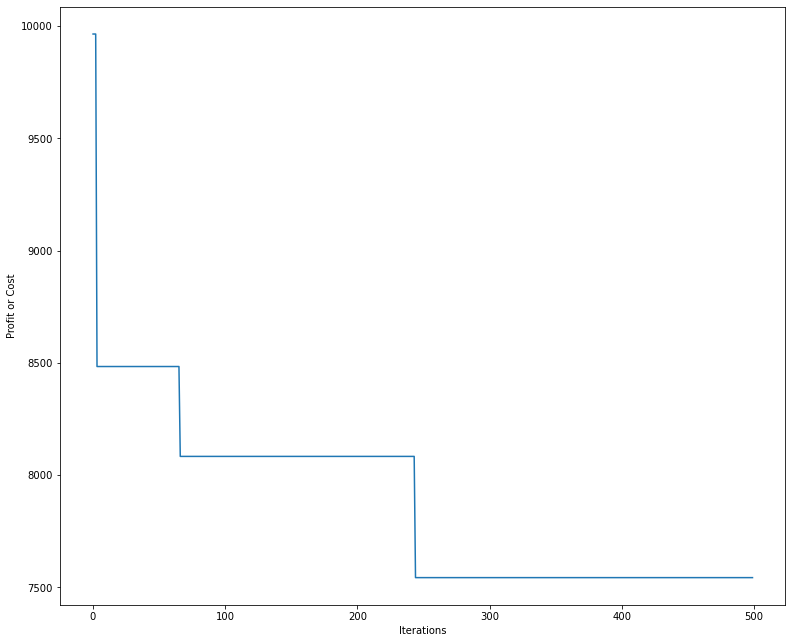

In [336]:
# _colony_size = 10
_steps = 500
_nodes = [(stations['lat'][i], stations['lon'][i]) for i, _ in nodes]
print(_nodes)
print(task_list)
# solver 1: by distance
start = time.process_time()
ACO_solver_1 = SolveTSPUsingACO(mode='dis', colony_size=_colony_size, steps=_steps, nodes=_nodes, tasks=task_list.copy())
ACO_solver_1.run()
end = time.process_time()
print("CPU Time: ", end - start, "s")
ACO_solver_1.visualize_graph()

In [217]:
pickup_nodes = [poi(stations['address'][nodes[i][0]],'canada',stations['lat'][nodes[i][0]], stations['lon'][nodes[i][0]]) for i in ACO_solver_1.global_best_tour]
drawRouteOrder(
    [x.coordinates[::-1] for x in pickup_nodes],
    pickup_nodes,
    range(1,len(pickup_nodes)+1), 
    route_color="red", m=None, prefix="")

### The second ACO solver is optimized by maximizing completion score


Started : comp
Ended : comp
Sequence : <- 3 - 5 - 0 - 1 - 13 - 19 - 4 - 9 - 17 - 7 ->
Total distance travelled to complete the tour : 13635.0

Actions: 
 [-29, 19, -16, 13, -17, 8, -7, 2, -3]
Completion Score: 
 0.5757575757575758
Distance per Completion Score: 
 23681.84210526316


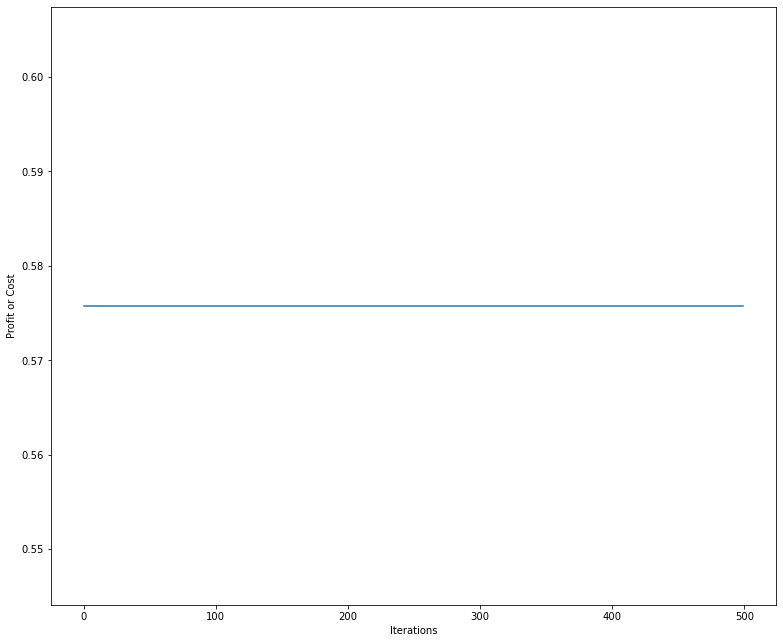

In [251]:
# solver 2: by completion score
ACO_solver_2 = SolveTSPUsingACO(mode='comp', colony_size=_colony_size, steps=_steps, nodes=_nodes, tasks=task_list.copy())
ACO_solver_2.run()
ACO_solver_2.visualize_graph()

In [252]:
pickup_nodes = [poi(stations['address'][nodes[i][0]],'canada',stations['lat'][nodes[i][0]], stations['lon'][nodes[i][0]]) for i in ACO_solver_2.global_best_tour]
drawRouteOrder(
        [x.coordinates[::-1] for x in pickup_nodes],
        pickup_nodes,
        range(1,len(pickup_nodes)+1), 
        route_color="red", m=None, prefix="")

### The third ACO solver is optimized by minimizing distance/completion_score


Started : ratio
Ended : ratio
Sequence : <- 1 - 5 - 0 - 3 - 13 - 19 - 4 - 9 - 17 - 7 ->
Total distance travelled to complete the tour : 13903.0

Actions: 
 [-29, 19, -20, 13, -13, 8, -7, 2, -3]
Completion Score: 
 0.5757575757575758
Distance per Completion Score: 
 24147.315789473683


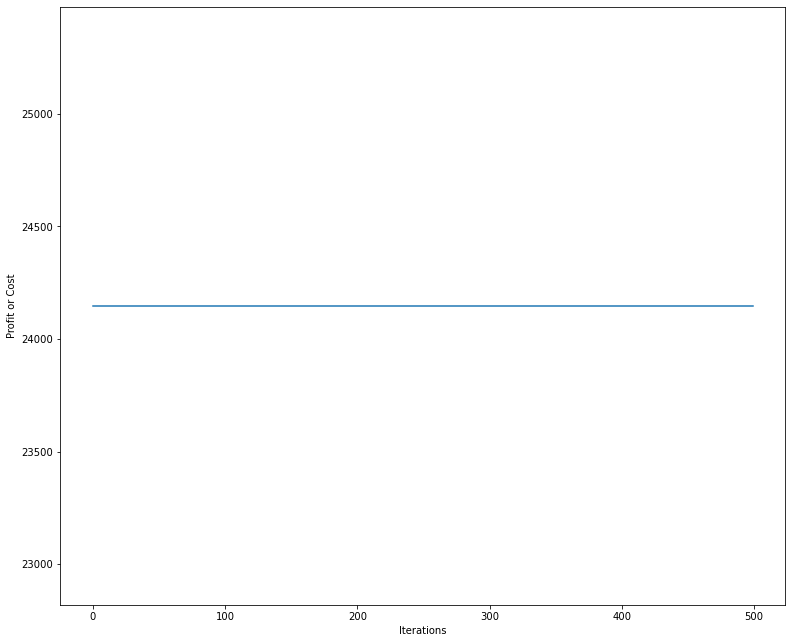

In [253]:
# solver 3: by minimizing the ratio of distance/completion_score
ACO_solver_3 = SolveTSPUsingACO(mode='ratio', colony_size=_colony_size, steps=_steps, nodes=_nodes, tasks=task_list.copy())
ACO_solver_3.run()
ACO_solver_3.visualize_graph()

In [248]:
pickup_nodes = [poi(stations['address'][nodes[i][0]],'canada',stations['lat'][nodes[i][0]], stations['lon'][nodes[i][0]]) for i in ACO_solver_3.global_best_tour]
drawRouteOrder(
        [x.coordinates[::-1] for x in pickup_nodes],
        pickup_nodes,
        range(1,len(pickup_nodes)+1), 
        route_color="red", m=None, prefix="")

### Genetic Algorithm with an Adaptive option

In [337]:
# Adaptive GA
class CarSharingSolver:
    def __init__(
        self,
        mode,
        pickup_nodes,
        tasks,
        trip_matrix,
        pop_size,
        iterations,
        num_parents,
        mutation_prob,
        crossover_prob,
        isAdaptive = False,
        mutation_const = 0,
        truck_size = 30,
        num_bikes = 30
    ):
        self.mode = mode
        self.pickups = pickup_nodes
        self.tasks = tasks
        self.trip_matrix = trip_matrix
        self.pop_size = pop_size
        self.iterations = iterations
        self.num_parents = num_parents
        self.mutation_prob = mutation_prob
        self.crossover_prob = crossover_prob
        self.population = None
        self.costs = None
        self.states = []       
        self.solution = None
        self.distance = None
        self.completion_score = None
        self.distance_per_completion_score = None
        self.isAdaptive = isAdaptive
        self.mutation_const = mutation_const
        self.num_bikes = num_bikes
        self.truck_size = truck_size

    def crossover(parent1, parent2):
        return ordOne_crossover(parent1, parent2)

    def mutation(permutation):
        return swap_mutation(permutation)

    def random_solution(self):
        route = []
        can_visit = deepcopy(self.pickups)
        for i in range(len(self.pickups)):
            # select a random pickup location
            random_pickup = random.choice(can_visit)
            route.append(random_pickup)
            can_visit.pop(can_visit.index(random_pickup))
        return route
    
    # operator's optimal action at the station with task = next_task
    def action(self, next_task, num_bikes):
        action = 0.0
        if next_task > 0:
            # drop off bikes to this station
            action = min(num_bikes, next_task)
        else:
            # pick up bikes from this station
            action = max(-(self.truck_size - num_bikes), next_task)
        return action
    
    def select_node(self, can_visit, num_bikes):
        # all possible candidates that is worth visiting
        candidates = []
        actions = []
        for node in can_visit:
            action = self.action(self.tasks[node], num_bikes)
            if not action == 0:
                candidates.append(node)
                actions.append(action)
        if len(candidates):
            # find a random one
            selected_node = random.choice(candidates)
            return selected_node, actions[candidates.index(selected_node)]
        return -1, 0
    
    def find_tour(self):
        route = []
        actions = []
        can_visit = deepcopy(self.pickups)
        num_bikes = self.num_bikes
        while len(route) < len(self.pickups):
            selected_node, action = self.select_node(can_visit, num_bikes)
            if action == 0:
                # no more stations worth visiting
                break
            route.append(selected_node)
            actions.append(action)
            can_visit.pop(can_visit.index(selected_node))
            num_bikes -= action
        return route#, actions

    def fitness(self, solutions):
        distance_result = []
        completion_result = []
        for route in solutions:
            distance = 0.0
            completion = 0
            # first stop
            action = self.action(self.tasks[route[0]], self.num_bikes)
            bikes = self.num_bikes - action
            completion += abs(action)
            for stop, next_stop in zip(route[:-1], route[1:]):
                # based on actions and distance
                action = self.action(self.tasks[next_stop], bikes)
                completion += abs(action)
                distance += self.trip_matrix[stop][next_stop]
                bikes -= action
                ###
            distance_result.append(round(distance,2))
            completion_result.append(round(completion,2))
        return distance_result, completion_result
    
    def initial_population(self):
        self.population = [
            self.find_tour()
            for _ in range(self.pop_size)
        ]
        self.distance, self.completion_score = self.fitness(self.population)

    # Single vehicle, genetic algorithm
    def run(self):
        # Check that initial population exists:
        mode = self.mode
        if mode == 'dis':
            print("optimizing by minimizing distance")
        elif mode == 'comp':
            print("optimizing by maximizing completion score")
        else:
            print("optimizing by minimizing ratio of distance/completion_score")
        if self.population:
            # Show some information
            print("Initial Population distance and completion:")
            print(self.distance, self.completion_score)
        else:
            raise Exception("Population not initialized.")
        # set initial mutation probability 
        ################## START NEW CODE ####################
        sig = 0.5
        mutation_lst = []
        max_mutation = 0
        ################## END NEW CODE ####################
        for x in range(self.iterations):
            self.distance, self.completion_score = self.fitness(self.population)
            # switch mode
            if mode == 'dis':
                # by distance
                self.costs = self.distance
                self.states.append(min(self.costs))
            elif mode == 'comp':
                self.costs = [a / sum_abs(self.tasks) for a in self.completion_score]
                self.states.append(max(self.costs))
            else:
                self.costs = [a/b for a,b in zip(self.distance,self.completion_score)]
                self.states.append(min(self.costs))
            ################## START NEW CODE ####################
#             # For adaptive GA only
            if self.isAdaptive:
                # add the current cost
                mutation_lst.extend(self.costs) 
                # adapts every 10 times
                if x % 10 == 0: 
                    z = sum([1 for i in mutation_lst if i >= max_mutation])
                    if (z/len(mutation_lst)*100) > 20:
                        sig /= self.mutation_const
                    elif (z/len(mutation_lst)*100) < 20:
                        sig *= self.mutation_const
                    max_mutation = max(mutation_lst)
                    # clear the list
                    mutation_lst = []
            ################## END NEW CODE ####################
            
            # Select the parents, we want to maximize the profit
            parents = []
            if mode == 'dis':
                parents = nsmallest(self.num_parents,self.population, key=lambda x: self.costs[self.population.index(x)])
            elif mode == 'comp':
                parents = nlargest(self.num_parents,self.population, key=lambda x: self.costs[self.population.index(x)])
            else:
                parents = nsmallest(self.num_parents,self.population, key=lambda x: self.costs[self.population.index(x)])
            offspring = []
            new_population = []
            for p1, p2 in zip(parents[:len(parents)//2],parents[len(parents)//2:]):
                # Crossover probability
                if random.random() < self.crossover_prob:
                    offspring.append(CarSharingSolver.crossover(p1,p2))
                    offspring.append(CarSharingSolver.crossover(p2,p1))
                else:
                    offspring.append(p1)
                    offspring.append(p2)
            for child in offspring:
                if random.random() < self.mutation_prob:
                    new_population.append(CarSharingSolver.mutation(child))
                else:
                    new_population.append(child)
            new_population.extend(parents)

        # Show best solution
        self.distance, self.completion_score = self.fitness(self.population)
        if mode == 'dis':
            self.states.append(min(self.distance))
            self.solution = min(self.population,key= lambda x: self.distance[self.population.index(x)])
        elif mode == 'comp':
            self.states.append(max(self.completion_score)/sum_abs(self.tasks))
            self.solution = max(self.population,key= lambda x: self.completion_score[self.population.index(x)])
        else:
            self.states.append(min([a/b for a,b in zip(self.distance,self.completion_score)]))
            self.solution = min(self.population,key= lambda x: self.distance[self.population.index(x)] / self.completion_score[self.population.index(x)])

        self.solution_completion_score = self.completion_score[self.population.index(self.solution)]
        self.solution_distance = self.distance[self.population.index(self.solution)]
        print("Best Solution:", self.solution)
        print("Best Solution Distance:", self.solution_distance)
        print("Best Solution Completion_score:", self.solution_completion_score / sum_abs(self.tasks))
        print("Best Solution Distance / Completion_score:", self.solution_distance / (self.solution_completion_score / sum_abs(self.tasks)))
        

    def visualize_solution(self, m=None, route_color="red", prefix=""):
        # define marker colors
        colors = []
        for stop in self.solution:
            colors.append('red')
        return drawRouteOrder(
            [nodes_coordinates[x] for x in self.solution],
            self.solution,
            range(1,len(self.solution)+1), 
            colors=colors, route_color=route_color, m=m, prefix=prefix)
    
    def visualize_graph(self):
        plt.plot(self.states)
        plt.xlabel("Iterations")
        if self.mode == 'dis':
            plt.ylabel("Distance/meters")
        elif self.mode == 'comp':
            plt.ylabel("Completion Score")
        else:
            plt.ylabel("Distance / Completion_score")
        plt.show()    

In [338]:
# parameters
pop_size = 10
iterations = 500
num_parents = 8
mutation_prob = 0.3
crossover_prob = 0.7
nodes_index = list(range(20))
truck_size = 30
num_bikes = 30

        
# run the solver by optimizing distance
start = time.process_time()

GA_solver_1 = CarSharingSolver(
    'dis',
    nodes_index, 
    task_list,
    distance_matrix, 
    pop_size, 
    iterations, 
    num_parents, 
    mutation_prob, 
    crossover_prob,
    truck_size,
    num_bikes)

# Initialize the population

GA_solver_1.initial_population()
GA_solver_1.run()
end = time.process_time()
print("CPU Time: ", end - start, "s")

print("##########")

# run the solver
start = time.process_time()

GA_solver_2 = CarSharingSolver(
    'comp',
    nodes_index, 
    task_list,
    distance_matrix, 
    pop_size, 
    iterations, 
    num_parents, 
    mutation_prob, 
    crossover_prob,
    truck_size,
    num_bikes)

# Initialize the population
GA_solver_2.initial_population()
GA_solver_2.run()
end = time.process_time()
print("CPU Time: ", end - start, "s")
print("##########")

# run the solver
start = time.process_time()

GA_solver_3 = CarSharingSolver(
    'ratio',
    nodes_index, 
    task_list,
    distance_matrix, 
    pop_size, 
    iterations, 
    num_parents, 
    mutation_prob, 
    crossover_prob,
    truck_size,
    num_bikes)

# Initialize the population
GA_solver_3.initial_population()
GA_solver_3.run()
end = time.process_time()
print("CPU Time: ", end - start, "s")

optimizing by minimizing distance
Initial Population distance and completion:
[34700.6, 22047.5, 23409.7, 34680.4, 28089.7, 31286.5, 19333.1, 27782.5, 30740.3, 39988.4] [114, 110, 114, 114, 114, 114, 104, 106, 114, 114]
Best Solution: [10, 17, 4, 5, 18, 13, 19, 0, 6, 16, 15]
Best Solution Distance: 19333.1
Best Solution Completion_score: 0.5252525252525253
Best Solution Distance / Completion_score: 36807.24807692307
CPU Time:  0.07668100000000777 s
##########
optimizing by maximizing completion score
Initial Population distance and completion:
[26443.7, 27496.1, 26439.9, 31725.9, 45067.4, 32049.1, 32075.6, 23445.4, 32742.0, 26605.0] [78, 114, 114, 114, 114, 114, 114, 114, 114, 82]
Best Solution: [2, 9, 16, 15, 17, 5, 13, 19, 4, 3, 0, 8, 7, 14]
Best Solution Distance: 27496.1
Best Solution Completion_score: 0.5757575757575758
Best Solution Distance / Completion_score: 47756.38421052631
CPU Time:  0.05935399999998481 s
##########
optimizing by minimizing ratio of distance/completion_scor

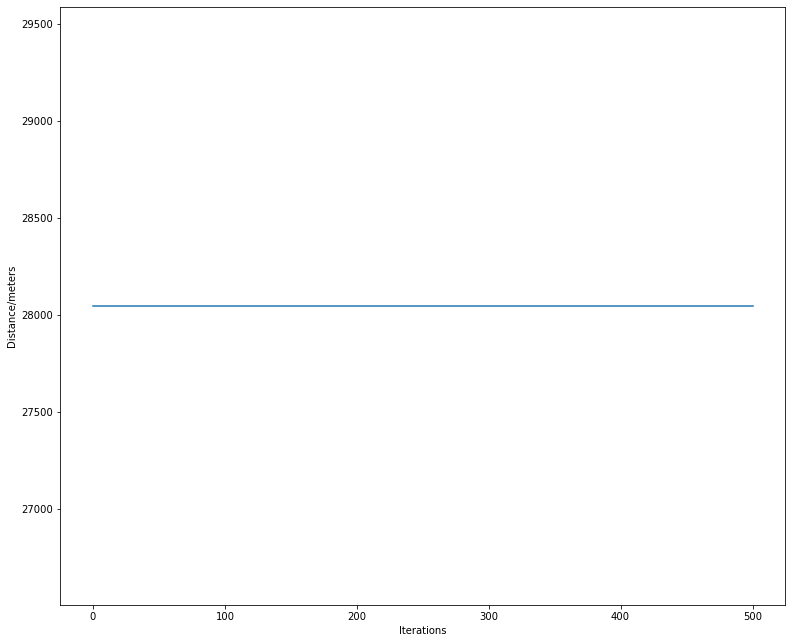

In [331]:
GA_solver_1.visualize_graph()

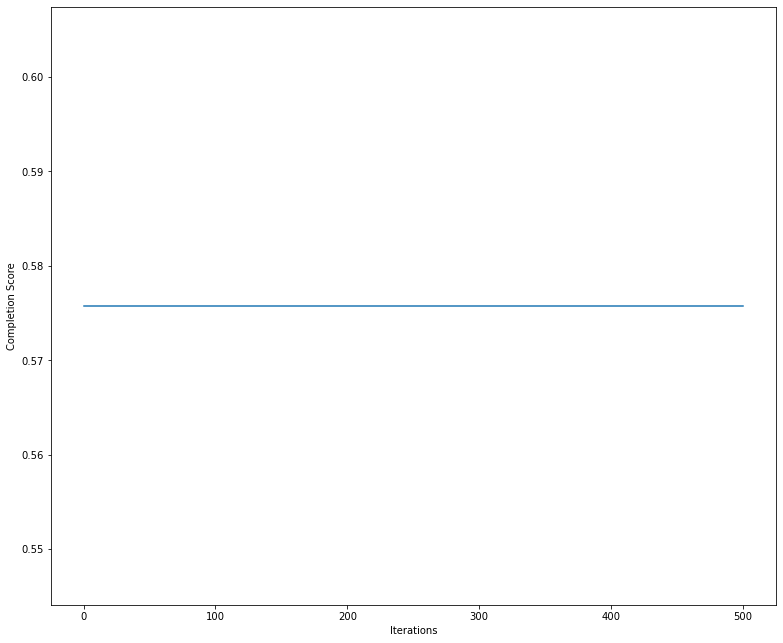

In [332]:
GA_solver_2.visualize_graph()

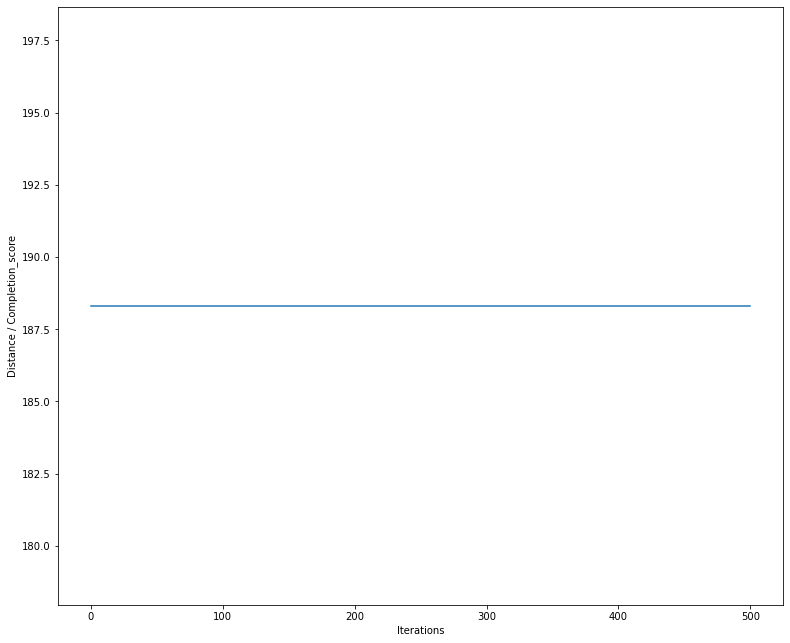

In [333]:
GA_solver_3.visualize_graph()

In [328]:
# plot stations map
pickup_nodes = [poi(stations['address'][nodes[i][0]],'canada',stations['lat'][nodes[i][0]], stations['lon'][nodes[i][0]]) for i in GA_solver_3.solution]
drawRouteOrder(
    [x.coordinates[::-1] for x in pickup_nodes],
    pickup_nodes,
    range(1,len(pickup_nodes)+1), 
    route_color="red", m=None, prefix="")


In [277]:
#helper functions
def sum_abs(a):
    return sum([abs(number) for number in a])

# def action(next_task, bikes):
#     action = 0.0
#     if next_task > 0:
#         # drop off bikes to this station
#         action = min(bikes, next_task)
#     else:
#         # pick up bikes from this station
#         action = max(-(30 - bikes), next_task)
#     return action